## Dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

dataset_path = '../../data/dataset-2.json'
df = pd.read_json(dataset_path).replace(np.nan, 0)

# Get all columns cointaining the tags'
tag_columns = [col for col in df.columns if col.startswith('tags.')]
tags_df = df[tag_columns]

# The dictionary mapping them into super categories
super_categories = {
    'implementation': [
        'tags.implementation', 'tags.constructive algorithms'
    ],
    'maths': [
        'tags.math', 'tags.geometry', 'tags.matrices', 'tags.combinatorics', 'tags.probabilities', 
        'tags.number theory', 'tags.chinese remainder theorem', 'tags.fft',
    ],
    'graphs': [
        'tags.trees', 'tags.dsu', 'tags.shortest paths', 'tags.data structures',
        'tags.dfs and similar', 'tags.flows', 'tags.graphs', 'tags.graph matchings',
    ],
    'optimization': [
        'tags.greedy', 'tags.dp', 'tags.two pointers', 'tags.sortings', 'tags.brute force', 
        'tags.binary search', 'tags.divide and conquer', 'tags.meet-in-the-middle', 
    ],
    'special-strings': [
        'tags.*special', 'tags.2-sat', 'tags.ternary search', 'tags.schedules', 'tags.games', 
        'tags.bitmasks', 'tags.interactive', 'tags.strings', 'tags.string suffix structures', 
        'tags.hashing', 'tags.expression parsing',
    ]
}

# Create the columns for the super categories
supertag_columns = [f'supertag.{key}' for key in super_categories]
for key in supertag_columns:
    df[key] = df[super_categories[key.split('.')[1]]].any(axis=1)
df[supertag_columns] = df[supertag_columns].astype(int)
y_data = df[supertag_columns].values

# Preprocessing

In [2]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

def clean_text(text):
    text=text.replace('+',' plus ')
    text=text.replace('-',' minus ')
    text=text.replace('*',' times ')
    text=text.replace('^',' power ')
    text=text.replace('/',' divide ')
    text=text.replace('<',' le ')
    text=text.replace('>',' ge ')
    text=text.replace('≤',' leq ')
    text=text.replace('<=',' leq ')
    text=text.replace('≥',' geq ')
    text=text.replace('>=',' geq ')
    text=text.replace('=',' equal ')
    text=text.replace('#',' numerical ')
    
    text = re.sub(r'[_\'\"]', '', text)

    text = re.sub(r'\W', ' ', text)
    return text

# Create the wordbag of tokens
wordbag = set()
statements = df['statement'].apply(str.lower).apply(clean_text)
stop_words = set(stopwords.words('english'))
tokens = [[word for word in word_tokenize(st) if word not in stop_words and word] for st in statements]

for st_tok in tokens:
    wordbag.update(set(st_tok))

# Convert the wordbag into numbers
idx2word = {i + 1: word for i, word in enumerate(wordbag)}
word2idx = {word: i + 1 for i, word in enumerate(wordbag)}
x_tokens = [[word2idx[word] for word in st_tok] for st_tok in tokens]

# Pad the sequences
x_tokens = pad_sequences(x_tokens, padding='post', maxlen=500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Embbedings

In [3]:
from gensim.models import Word2Vec

emb_size=128
sg_model = Word2Vec.load(f'../models/sg_{emb_size}.model')

def get_embedding_matrix(x_tokens, w2vModel):
    new_x_data = []
    for row in x_tokens:
        new_row = []
        for word in row:
            new_row.append(w2vModel.wv[idx2word[word]] if word != 0 and (idx2word[word] in w2vModel.wv) else np.zeros(emb_size))
        new_x_data.append(new_row)
    return np.array(new_x_data)

# Model Training

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_tokens, y_data, train_size=0.08, test_size=0.02, random_state=42)
x_train = get_embedding_matrix(x_train, sg_model)
x_test = get_embedding_matrix(x_test, sg_model)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, AveragePooling1D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, mode='max', restore_best_weights=True)

def create_model(
    conv_filters=64,
    conv_kernel_size=5,
    strides=2,
    lstm_units=128, 
    dense_units=64, 
    dropout_rate=0.5, 
    recurrent_dropout=0.5, 
    kernel_regularizer=True,
    dense_activation=None,
    ):
    model = Sequential()
    model.add(Conv1D(conv_filters, conv_kernel_size, strides=strides, activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add (AveragePooling1D(conv_kernel_size))
    model.add(Bidirectional(LSTM(lstm_units, recurrent_dropout=recurrent_dropout, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, recurrent_dropout=recurrent_dropout, kernel_regularizer=(L2(0.001) if kernel_regularizer else None))))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, kernel_regularizer=(L2(0.001) if kernel_regularizer else None), activation=dense_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['binary_accuracy'])
    
    return model

def train_model(model):
    tf.compat.v1.reset_default_graph()
    return model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

In [9]:
import matplotlib.pyplot as plt

def graph_metrics(history):
    real_epochs = len(history.history['binary_accuracy'])
    x_epochs = [i for i in range(real_epochs)]
    plt.plot(x_epochs, history.history['binary_accuracy'], x_epochs, history.history['val_binary_accuracy'])
    plt.legend(['training set', 'validation set'])
    plt.xlabel('Epochs')
    plt.ylabel('Binary Accuracy')
    plt.show()
    print(f"Max validation accuracy: {max(history.history['val_binary_accuracy'])}")

## Comparing models

c:\Users\enriq\Documents\MyDocuments\University\S8\RedesNeuronales\finalProject\cp-problem-classifier\workspace\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


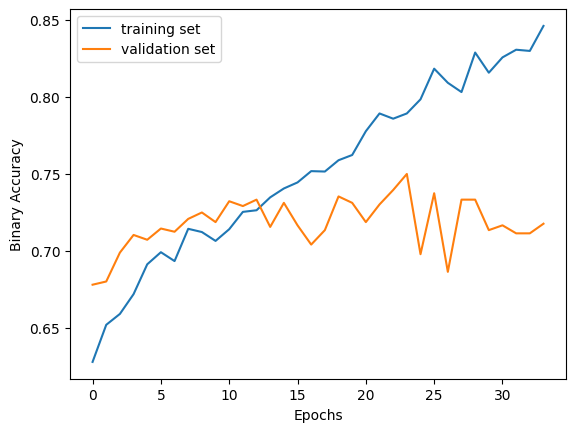

Max validation accuracy: 0.75


In [22]:
current_model = create_model()
history = train_model(current_model)
graph_metrics(history)

c:\Users\enriq\Documents\MyDocuments\University\S8\RedesNeuronales\finalProject\cp-problem-classifier\workspace\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


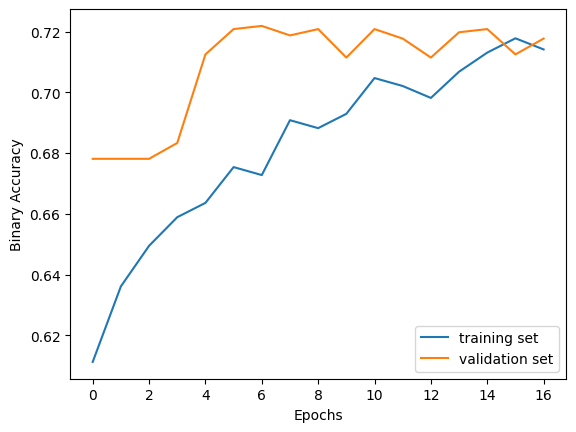

Max validation accuracy: 0.7218749523162842


In [10]:
current_model = create_model(conv_filters=32, lstm_units=64, dense_units=32)
history = train_model(current_model)
graph_metrics(history)

c:\Users\enriq\Documents\MyDocuments\University\S8\RedesNeuronales\finalProject\cp-problem-classifier\workspace\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


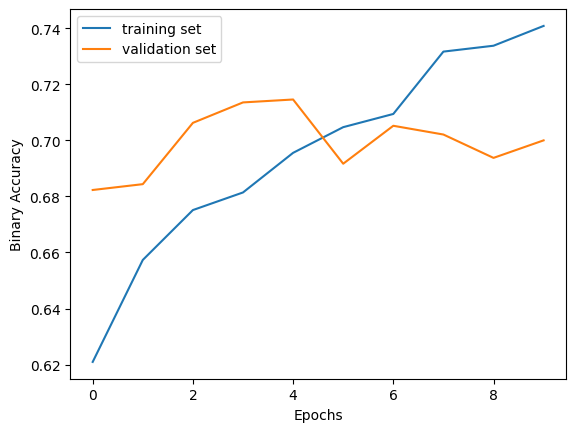

Max validation accuracy: 0.7145832180976868


In [88]:
current_model = create_model(conv_filters=128, lstm_units=256, dense_units=128)
history = train_model(current_model)
graph_metrics(history)

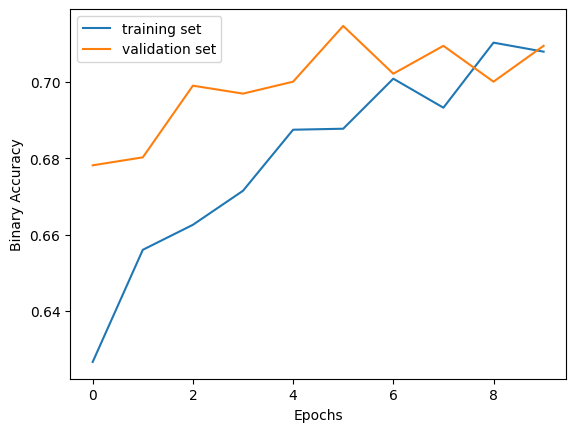

Max validation accuracy: 0.7145833969116211


In [89]:
current_model = create_model(conv_kernel_size=3)
history = train_model(current_model)
graph_metrics(history)

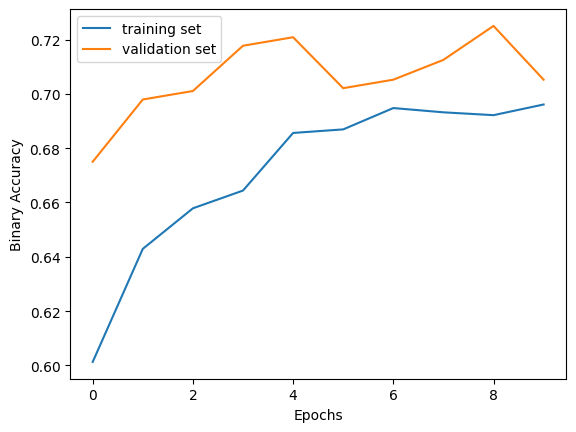

Max validation accuracy: 0.7249999642372131


In [23]:
current_model = create_model(conv_kernel_size=3, strides=1)
history = train_model(current_model)
graph_metrics(history)

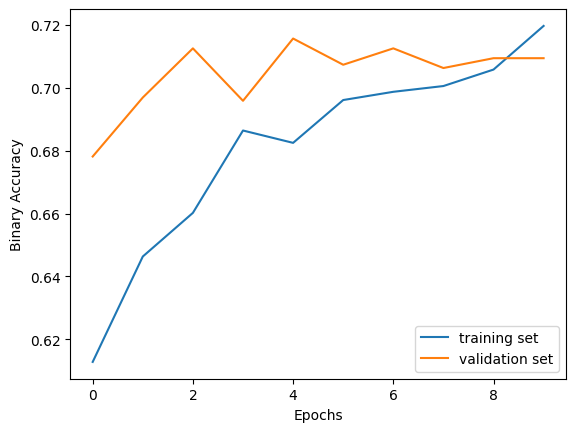

Max validation accuracy: 0.715624988079071


In [91]:
current_model = create_model(conv_kernel_size=10)
history = train_model(current_model)
graph_metrics(history)

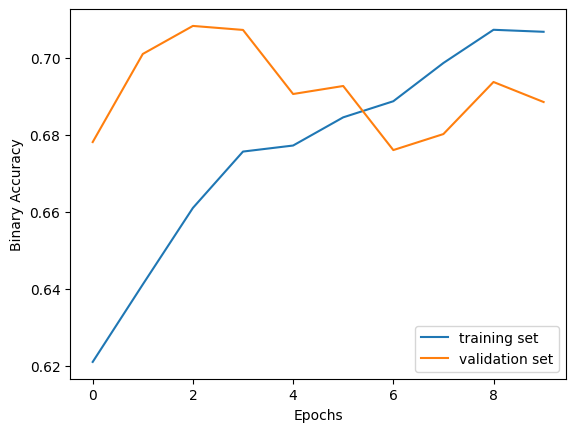

Max validation accuracy: 0.7083333134651184


In [93]:
current_model = create_model(conv_kernel_size=10, strides=1)
history = train_model(current_model)
graph_metrics(history)

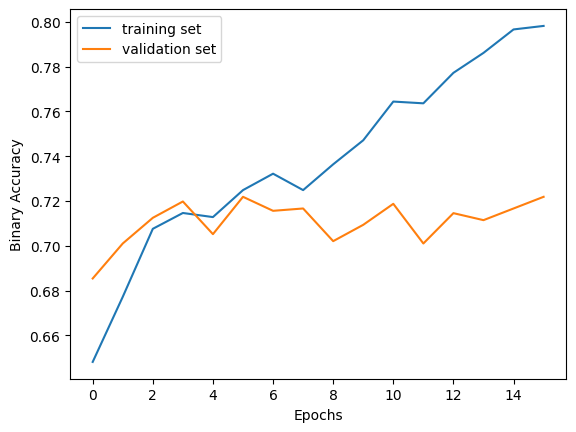

Max validation accuracy: 0.721875011920929


In [11]:
current_model = create_model(dropout_rate=0.0, recurrent_dropout=0.0)
history = train_model(current_model)
graph_metrics(history)

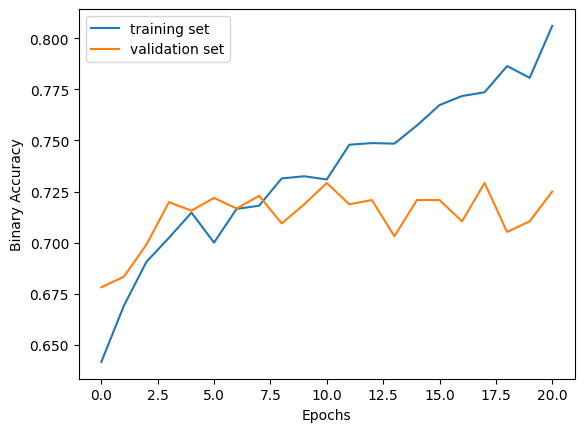

Max validation accuracy: 0.7291667461395264


In [12]:
current_model = create_model(dropout_rate=0.0)
history = train_model(current_model)
graph_metrics(history)

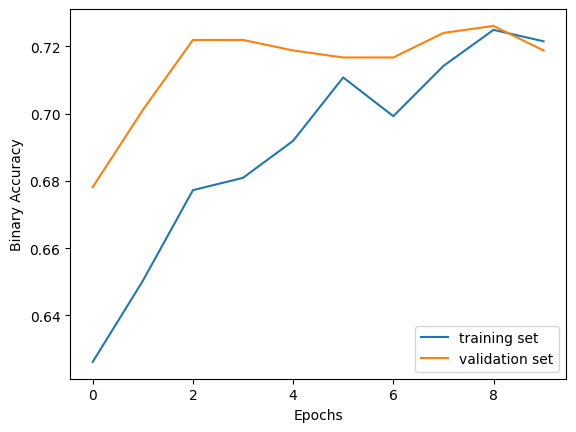

Max validation accuracy: 0.7260417342185974


In [13]:
current_model = create_model(recurrent_dropout=0.0)
history = train_model(current_model)
graph_metrics(history)

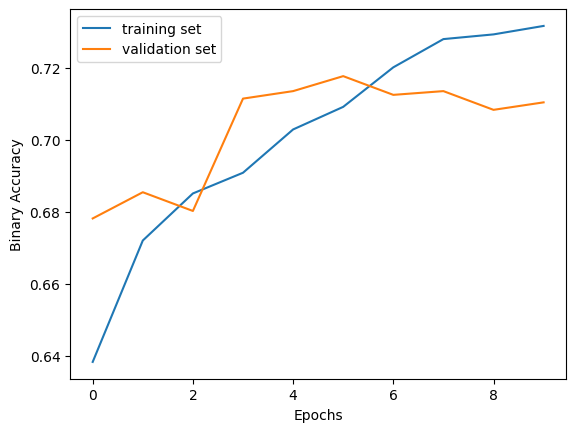

Max validation accuracy: 0.7177083492279053


In [14]:
current_model = create_model(dropout_rate=0.2, recurrent_dropout=0.2)
history = train_model(current_model)
graph_metrics(history)

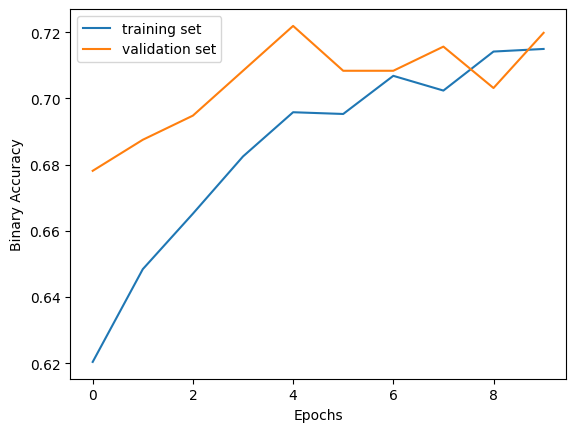

Max validation accuracy: 0.721875011920929


In [24]:
current_model = create_model(kernel_regularizer=False)
history = train_model(current_model)
graph_metrics(history)

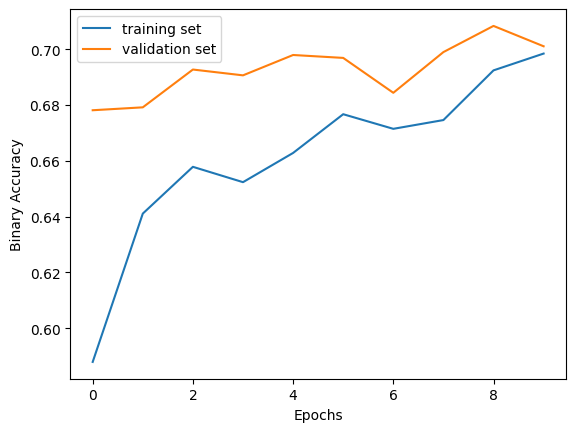

Max validation accuracy: 0.7083333134651184


In [25]:
current_model = create_model(dense_activation='relu')
history = train_model(current_model)
graph_metrics(history)